<a href="https://colab.research.google.com/github/kand11/machineLearning/blob/main/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# МЛ Практика 3: Подбор признаков и валидация моделей

## **Цель занятия:**
Изучить методы поиска значимых признаков в данных. На практике мы проведем анализ целевой переменной **Y**, применим методы для поиска значимых признаков, обучим линейную модель, проанализируем результат и оценим валидность модели.

## **Задание состоит из следующих частей:**
1. Обработка выбросов;
1. Поиск значимых признаков с использованием библиотеки **sklearn**.
2. Обучение логистической регресси модели и оценка ее точности.
6. Кросс-валидация с использованием разных методов (K-fold, ShuffleSplit, test-train-validation)

## 1: Загрузка библиотек и предобратка данных

In [1]:
!pip install pandas scikit-learn seaborn scipy

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.feature_selection import SelectKBest, chi2, RFE, SelectFromModel

In [3]:
# Загрузка набора данных
df = pd.read_csv('/content/facebook.csv')

In [4]:
df

,status_id,status_type,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
0,246675545449582_1649696485147474,video,4/22/2018 6:00,529,512,262,432,92,3,1,1,0
1,246675545449582_1649426988507757,photo,4/21/2018 22:45,150,0,0,150,0,0,0,0,0
2,246675545449582_1648730588577397,video,4/21/2018 6:17,227,236,57,204,21,1,1,0,0
3,246675545449582_1648576705259452,photo,4/21/2018 2:29,111,0,0,111,0,0,0,0,0
4,246675545449582_1645700502213739,photo,4/18/2018 3:22,213,0,0,204,9,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
7045,1050855161656896_1061863470556065,photo,9/24/2016 2:58,89,0,0,89,0,0,0,0,0
7046,1050855161656896_1061334757275603,photo,9/23/2016 11:19,16,0,0,14,1,0,1,0,0
7047,1050855161656896_1060126464063099,photo,9/21/2016 23:03,2,0,0,1,1,0,0,0,0
7048,1050855161656896_1058663487542730,photo,9/20/2016 0:43,351,12,22,349,2,0,0,0,0


In [5]:
df = df.drop('status_id', axis=1)
df = df.drop('status_type', axis=1)
df = df.drop('status_published', axis=1)

In [6]:
df['is_popular_post'] = np.where(df['num_likes'] >= 100, 1, 0)
df.is_popular_post = df.is_popular_post.astype('category')
# df['type'] = df['type'].astype('category')

In [7]:
Y = df['is_popular_post'] # выбираем целевую переменную (категориальную)
X = df.drop('is_popular_post', axis=1) # переменные для проверки влияния

# В моем случае я дропаю базовую переменную, а не только. Y
X = X.drop('num_likes', axis=1)

In [8]:
df.drop('num_likes', axis=1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7050 entries, 0 to 7049
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   num_reactions    7050 non-null   int64   
 1   num_comments     7050 non-null   int64   
 2   num_shares       7050 non-null   int64   
 3   num_loves        7050 non-null   int64   
 4   num_wows         7050 non-null   int64   
 5   num_hahas        7050 non-null   int64   
 6   num_sads         7050 non-null   int64   
 7   num_angrys       7050 non-null   int64   
 8   is_popular_post  7050 non-null   category
dtypes: category(1), int64(8)
memory usage: 447.8 KB


In [9]:
df

,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,is_popular_post
0,529,512,262,432,92,3,1,1,0,1
1,150,0,0,150,0,0,0,0,0,1
2,227,236,57,204,21,1,1,0,0,1
3,111,0,0,111,0,0,0,0,0,1
4,213,0,0,204,9,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
7045,89,0,0,89,0,0,0,0,0,0
7046,16,0,0,14,1,0,1,0,0,0
7047,2,0,0,1,1,0,0,0,0,0
7048,351,12,22,349,2,0,0,0,0,1


## 2: масштабирование признаков

In [10]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7050 entries, 0 to 7049
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   num_reactions  7050 non-null   int64
 1   num_comments   7050 non-null   int64
 2   num_shares     7050 non-null   int64
 3   num_loves      7050 non-null   int64
 4   num_wows       7050 non-null   int64
 5   num_hahas      7050 non-null   int64
 6   num_sads       7050 non-null   int64
 7   num_angrys     7050 non-null   int64
dtypes: int64(8)
memory usage: 440.8 KB


In [11]:
# Создаем копию данных
X_processed = X.copy()

category_columns: list[str] = X_processed.select_dtypes(include=['category']).columns # собираем колонки помеченные как category

# Применяем One-Hot Encoding
X_processed = pd.get_dummies(X_processed, columns=category_columns,drop_first=True) # drop_first=True позволяет избежать мультиколлинеарности, удаляя первый уровень категориальной переменной.


In [12]:
X_processed

,num_reactions,num_comments,num_shares,num_loves,num_wows,num_hahas,num_sads,num_angrys
0,529,512,262,92,3,1,1,0
1,150,0,0,0,0,0,0,0
2,227,236,57,21,1,1,0,0
3,111,0,0,0,0,0,0,0
4,213,0,0,9,0,0,0,0
...,...,...,...,...,...,...,...,...
7045,89,0,0,0,0,0,0,0
7046,16,0,0,1,0,1,0,0
7047,2,0,0,1,0,0,0,0
7048,351,12,22,2,0,0,0,0


In [13]:
# Выбираем числовые признаки
numeric_features = X_processed.select_dtypes(include=['int64']).columns.tolist()

# Инициализируем scaler
scaler = MinMaxScaler()

# Применяем нормализацию
X_processed[numeric_features] = scaler.fit_transform(X_processed[numeric_features])


In [14]:
X_processed

,num_reactions,num_comments,num_shares,num_loves,num_wows,num_hahas,num_sads,num_angrys
0,0.112314,0.024393,0.076519,0.140030,0.010791,0.006369,0.019608,0.0
1,0.031847,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,0.048195,0.011243,0.016647,0.031963,0.003597,0.006369,0.000000,0.0
3,0.023567,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,0.045223,0.000000,0.000000,0.013699,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...
7045,0.018896,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
7046,0.003397,0.000000,0.000000,0.001522,0.000000,0.006369,0.000000,0.0
7047,0.000425,0.000000,0.000000,0.001522,0.000000,0.000000,0.000000,0.0
7048,0.074522,0.000572,0.006425,0.003044,0.000000,0.000000,0.000000,0.0


## 3: Очистка данных и удаление выбросов

Важным шагом в машинном обучении - является очистка и удаление данных от выбросов.

### Методы обработки выбросов:

1. **Метод на основе медианы и межквартильного размаха (IQR)**:
   - **Как работает**:
     Метод основан на расчете межквартильного размаха (IQR), который вычисляется как разница между третьим (75-й перцентиль) и первым квартилем (25-й перцентиль). Данные считаются выбросами, если они выходят за пределы диапазона \([Q1 - 1.5 * IQR , Q3 + 1.5 * IQR]\).
   - **Зачем это нужно**:
     Выбросы могут серьезно искажать результаты моделей, особенно тех, которые основаны на средних значениях или предполагают нормальное распределение данных.
   - **Когда лучше использовать**:
     - Когда данные содержат **немного выбросов** и имеют **асимметричное распределение**.
     - Метод медианы и IQR более устойчив к выбросам по сравнению с методом, основанным на среднем значении, так как медиана меньше подвержена влиянию экстремальных значений.
     - Хорошо подходит для набора данных, которые не распределены нормально (например, зарплаты или цены на недвижимость).

2. **Метод на основе среднего (Mean)**:
   - **Как работает**:
     Метод использует средние значения и удаляет те признаки или записи, которые значительно отклоняются от среднего. Чаще всего это делается с помощью установления порога (например, данные, которые превышают 2 или 3 средних значения, считаются выбросами).
   - **Зачем это нужно**:
     Выбросы, сильно отличающиеся от средних значений, могут существенно влиять на такие модели, как линейная регрессия, так как среднее значение сильно чувствительно к экстремальным точкам.
   - **Когда лучше использовать**:
     - Когда данные имеют **нормальное распределение** или приближены к нормальному.
     - Подходит, если данные содержат **много выбросов**, и вам нужно жестче ограничить их влияние на модель.

### Как выбрать метод:

- **Если данные асимметричны** или распределены с "хвостами" (например, распределение доходов или цен), лучше использовать **метод на основе медианы и IQR**, так как медиана не чувствительна к выбросам и лучше описывает такие наборы данных.
  
- **Если данные нормально распределены** и важно учитывать всю выборку, даже если есть выбросы, можно использовать **метод на основе среднего**. Этот метод будет точнее отражать центр распределения в симметричных данных и позволит выявить значительные отклонения от него.

Оба метода помогают улучшить производительность моделей машинного обучения, обеспечивая более точное представление данных для анализа и обучения.

### Для начала определеим функцию обучения с оценкой качества (для простоты)

In [15]:
from sklearn.model_selection import cross_val_score

def train_and_evaluate(X, Y):
    # Разделение данных на обучающую и тестовую выборки
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.2, random_state=42, stratify=Y)

    # Инициализация модели
    model = LogisticRegression(max_iter=1000)

    # Обучение модели
    model.fit(X_train, Y_train)

    # Предсказания на обучающей выборке
    Y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(Y_train, Y_train_pred)

    # Предсказания на тестовой выборке
    Y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(Y_test, Y_test_pred)

    # Вывод результатов
    print(f"Точность на обучающей выборке: {train_accuracy:.4f}")
    print(f"Точность на тестовой выборке: {test_accuracy:.4f}")

    # Классификационный отчет
    print("\nКлассификационный отчет на тестовой выборке:")
    print(classification_report(Y_test, Y_test_pred))

    return model


In [16]:
train_and_evaluate(X_processed, Y)

Точность на обучающей выборке: 0.8615
Точность на тестовой выборке: 0.8546

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.82      0.98      0.89       852
           1       0.95      0.67      0.78       558

    accuracy                           0.85      1410
   macro avg       0.88      0.82      0.84      1410
weighted avg       0.87      0.85      0.85      1410



LogisticRegression(max_iter=1000)

### Метод 1: удаление на основе медианы

In [17]:
# Функция для удаления выбросов на основе межквартильного размаха (1.5 IQR)
def remove_outliers_based_on_iqr(X, y, iqr_multiplier=1.5):
    # Убедимся, что работаем только с числовыми данными
    X_numeric = X.select_dtypes(include=['number'])

    # Рассчитываем первый и третий квартили для каждой числовой переменной
    Q1 = X_numeric.quantile(0.25)
    Q3 = X_numeric.quantile(0.75)

    # Вычисляем межквартильный размах (IQR)
    IQR = Q3 - Q1

    # Оставляем только те значения, которые находятся в диапазоне [Q1 - 1.5*IQR, Q3 + 1.5*IQR]
    X_filtered = X_numeric[~((X_numeric < (Q1 - iqr_multiplier * IQR)) | (X_numeric > (Q3 + iqr_multiplier * IQR))).any(axis=1)]

    # Синхронизируем y с отфильтрованными X
    y_filtered = y.loc[X_filtered.index]

    return X_filtered, y_filtered


In [18]:
X_iqr, y_iqr = remove_outliers_based_on_iqr(X_processed, Y, iqr_multiplier=3)

In [19]:
X_processed.describe()

,num_reactions,num_comments,num_shares,num_loves,num_wows,num_hahas,num_sads,num_angrys
count,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000
mean,0.048857,0.010689,0.011689,0.019374,0.004638,0.004436,0.004778,0.003651
std,0.098222,0.042384,0.038435,0.060842,0.031366,0.025205,0.031317,0.023446
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.003609,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.012633,0.000191,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.046497,0.001096,0.001168,0.004566,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
X_iqr.describe()

,num_reactions,num_comments,num_shares,num_loves,num_wows,num_hahas,num_sads,num_angrys
count,4314.000000,4314.000000,4314.000000,4314.000000,4314.0,4314.0,4314.0,4314.0
mean,0.013317,0.000207,0.000201,0.000559,0.0,0.0,0.0,0.0
std,0.023441,0.000395,0.000575,0.001766,0.0,0.0,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,0.002335,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,0.004883,0.000048,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,0.012102,0.000238,0.000000,0.000000,0.0,0.0,0.0,0.0
max,0.172611,0.003907,0.004673,0.018265,0.0,0.0,0.0,0.0


In [21]:
train_and_evaluate(X_iqr, y_iqr)

Точность на обучающей выборке: 0.8560
Точность на тестовой выборке: 0.8470

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       724
           1       1.00      0.05      0.10       139

    accuracy                           0.85       863
   macro avg       0.92      0.53      0.51       863
weighted avg       0.87      0.85      0.78       863



LogisticRegression(max_iter=1000)

### ⏰ **Провести анализ выводов, посмотреть как изменились переменные и описать результат**
Точность осталась +- той же. Модель точно определила 1, но очень малую долю от всех единичек в принципе. C 0 ситуация немного другая. Модель нашла все 0 и даже некоторые 1 приняла за 0. Так же осталось чуть более половины всех данных.


### Метод 2: удаление на основе среднего

In [22]:
# Функция для удаления выбросов на основе среднего значения

def remove_outliers_based_on_mean(X, y, mean_multiplier=2):
    # Убедимся, что работаем только с числовыми данными
    X_numeric = X.select_dtypes(include=['number'])

    # Рассчитываем среднее значение и стандартное отклонение для каждой переменной
    mean_values = X_numeric.mean()
    std_values = X_numeric.std()

    # Устанавливаем верхний и нижний пороги на основе среднего значения и множителя стандартного отклонения
    lower_threshold = mean_values - mean_multiplier * std_values
    upper_threshold = mean_values + mean_multiplier * std_values

    # Фильтруем наблюдения, которые находятся в пределах этих порогов по всем признакам
    X_filtered = X_numeric[~((X_numeric < lower_threshold) | (X_numeric > upper_threshold)).any(axis=1)]

    # Синхронизируем y с отфильтрованными X
    y_filtered = y.loc[X_filtered.index]

    return X_filtered, y_filtered

In [23]:
X_mean, y_mean = remove_outliers_based_on_mean(X_processed.copy(), Y.copy())

In [24]:
X_processed.describe()

,num_reactions,num_comments,num_shares,num_loves,num_wows,num_hahas,num_sads,num_angrys
count,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000
mean,0.048857,0.010689,0.011689,0.019374,0.004638,0.004436,0.004778,0.003651
std,0.098222,0.042384,0.038435,0.060842,0.031366,0.025205,0.031317,0.023446
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.003609,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.012633,0.000191,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.046497,0.001096,0.001168,0.004566,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [25]:
X_mean.describe()

,num_reactions,num_comments,num_shares,num_loves,num_wows,num_hahas,num_sads,num_angrys
count,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000
mean,0.024366,0.003273,0.004381,0.008211,0.001800,0.001394,0.001100,0.000779
std,0.036501,0.010259,0.013763,0.022570,0.005063,0.005082,0.005900,0.004952
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.003185,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.008917,0.000143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.032059,0.000619,0.000584,0.003044,0.000000,0.000000,0.000000,0.000000
max,0.243100,0.093854,0.088493,0.140030,0.057554,0.050955,0.058824,0.032258


In [26]:
train_and_evaluate(X_mean, y_mean)

Точность на обучающей выборке: 0.8412
Точность на тестовой выборке: 0.8201

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.80      0.98      0.88       842
           1       0.91      0.48      0.63       392

    accuracy                           0.82      1234
   macro avg       0.86      0.73      0.76      1234
weighted avg       0.84      0.82      0.80      1234



LogisticRegression(max_iter=1000)

### ⏰ **Провести анализ выводов, посмотреть как измеились переменные и описать результат**
Точность стала меньше изначальной и меньше 1-ого метода, данных осталось почти 90 процетов. Можно заметить, что данных, сильно отличающихся от среднего не так уж и много было. Точность и полнота для 0 и 1 упала. В принципе ситуация никак не изменилась.


## 3: Методы отбора признаков

Отбор признаков (feature selection) — важный шаг в машинном обучении, который помогает улучшить качество моделей и ускорить их работу. Цель отбора — убрать лишние или малозначимые признаки, которые не влияют на предсказания модели, либо могут ухудшить её производительность.

Зачем это нужно:
1. **Улучшение производительности модели** — избыточные признаки могут создавать шум и снижать точность.
2. **Повышение интерпретируемости** — меньший набор признаков легче анализировать и объяснять.
3. **Снижение вычислительной сложности** — меньшее количество признаков ускоряет обучение и предсказание.

В sklearn основные методы отбора признаков включают:
1. **Filter методы** — основаны на статистических тестах, например, `SelectKBest` использует критерий, чтобы выбрать признаки с наибольшим вкладом.
2. **Wrapper методы** — оценивают модели на разных подмножествах признаков, например, рекурсивное исключение признаков (`RFE`).
3. **Embedded методы** — выполняют отбор признаков во время обучения модели, например, с помощью L1-регуляризации (Lasso).

### Filter методы

Filter методы основаны на статистических свойствах данных и выбирают признаки, не учитывая алгоритм машинного обучения. Они работают как предварительный шаг перед обучением модели и быстро отбирают наиболее информативные признаки.

Преимущества:

- Быстро выполняются.
- Не зависят от модели.
- Уменьшают размерность данных до обучения.

Недостатки:

- Не учитывают взаимодействие между признаками.
- Могут упускать важные комбинации признаков.

In [27]:
from sklearn.feature_selection import SelectKBest, f_regression


In [75]:
# Применяем SelectKBest для выбора 5 лучших признаков
selector = SelectKBest(score_func=f_regression, k=4)
X_kbest = selector.fit_transform(X_processed, Y)


In [36]:
selector.scores_

array([2740.56155143,  578.83583215,  766.79474405,  903.87297753,
        186.93064841,  227.82096875,  136.93987342,  157.29627739])

In [37]:
X_processed.columns

Index(['num_reactions', 'num_comments', 'num_shares', 'num_loves', 'num_wows',
       'num_hahas', 'num_sads', 'num_angrys'],
      dtype='object')

In [38]:
X_processed

,num_reactions,num_comments,num_shares,num_loves,num_wows,num_hahas,num_sads,num_angrys
0,0.112314,0.024393,0.076519,0.140030,0.010791,0.006369,0.019608,0.0
1,0.031847,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,0.048195,0.011243,0.016647,0.031963,0.003597,0.006369,0.000000,0.0
3,0.023567,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,0.045223,0.000000,0.000000,0.013699,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...
7045,0.018896,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
7046,0.003397,0.000000,0.000000,0.001522,0.000000,0.006369,0.000000,0.0
7047,0.000425,0.000000,0.000000,0.001522,0.000000,0.000000,0.000000,0.0
7048,0.074522,0.000572,0.006425,0.003044,0.000000,0.000000,0.000000,0.0


⏰ Изучите 1 из методов и используйте его как score_func (Важно учитывать, что не все методы могут подходить под тип признака, например chi2 подходит только для категориальных)

```**P.S. методы работают по разному для дискретных и непрерывных значений. Методы необходимо использовать для своих типов переменных!**```

[link](https://scikit-learn.org/stable/modules/feature_selection.html)

**f_classif**: ANOVA F-value between label/feature for classification tasks.

**mutual_info_classif**: Mutual information for a discrete target.

**chi2**: Chi-squared stats of non-negative features for classification tasks.

**f_regression**: F-value between label/feature for regression tasks.

**mutual_info_regression**: Mutual information for a continuous target.

**SelectPercentile**: Select features based on percentile of the highest scores.

**SelectFpr**: Select features based on a false positive rate test.

**SelectFdr**: Select features based on an estimated false discovery rate.

**SelectFwe**: Select features based on family-wise error rate.

**GenericUnivariateSelect**: Univariate feature selector with configurable mode.

In [76]:
selector.get_support(indices=True)

array([0, 1, 2, 3])

In [77]:
# Получаем список отобранных признаков
selected_features = X_processed.columns[selector.get_support(indices=True)]
print("Отобранные признаки:", selected_features)

Отобранные признаки: Index(['num_reactions', 'num_comments', 'num_shares', 'num_loves'], dtype='object')


In [78]:
# Преобразуем X_kbest в DataFrame
X_kbest_df = pd.DataFrame(X_kbest, columns=selected_features)

# Обучаем и оцениваем модель
train_and_evaluate(X_kbest_df, Y)

Точность на обучающей выборке: 0.8601
Точность на тестовой выборке: 0.8539

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.82      0.98      0.89       852
           1       0.95      0.67      0.78       558

    accuracy                           0.85      1410
   macro avg       0.88      0.82      0.84      1410
weighted avg       0.87      0.85      0.85      1410



LogisticRegression(max_iter=1000)

### Wrapper методы

Wrapper методы оценивают различные комбинации признаков, обучая модель на каждом подмножестве, и выбирают набор признаков, который дает наилучшее качество модели. Они учитывают взаимодействия между признаками, но могут быть вычислительно затратными.

Преимущества:

- Учитывают взаимодействия между признаками.
- Могут улучшить производительность модели.

Недостатки:

- Высокая вычислительная сложность.
- Длительное время выполнения на больших наборах данных.

In [80]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Инициализируем модель логистической регрессии
base_model = LogisticRegression(max_iter=1000)

# Инициализируем RFE для выбора 5 лучших признаков
rfe = RFE(estimator=base_model, n_features_to_select=4)
rfe.fit(X_processed, Y)

# Получаем список отобранных признаков
selected_features = X_processed.columns[rfe.support_]
print("Отобранные признаки:", selected_features)


Отобранные признаки: Index(['num_reactions', 'num_comments', 'num_shares', 'num_loves'], dtype='object')


In [64]:
# Отбираем признаки
X_rfe = X_processed[selected_features]

# Обучаем и оцениваем модель
model = train_and_evaluate(X_rfe, Y)


Точность на обучающей выборке: 0.8601
Точность на тестовой выборке: 0.8539

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.82      0.98      0.89       852
           1       0.95      0.67      0.78       558

    accuracy                           0.85      1410
   macro avg       0.88      0.82      0.84      1410
weighted avg       0.87      0.85      0.85      1410



### Embedded методы

Преимущества:

Учитывают взаимодействия между признаками.
- Менее вычислительно затратны, чем Wrapper методы.
- Интегрированы в процесс обучения.

Недостатки:

- Зависимы от выбранной модели.
- Могут не отбирать признаки, важные для других моделей.

Коэффициенты модели без регуляризации: [[30.59463194  4.93809328  4.45445421  8.75114859  2.28738192  1.86398385
   2.68204896  1.64089417]]
Коэффициенты модели с регуляризацией: [[317.65127859   0.           0.         -34.00565791   0.
    0.           0.           0.        ]]
Отобранные признаки: Index(['num_reactions', 'num_loves'], dtype='object')


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Коэффициенты модели после отбора признаков: [[318.48133432 -34.13022407]]


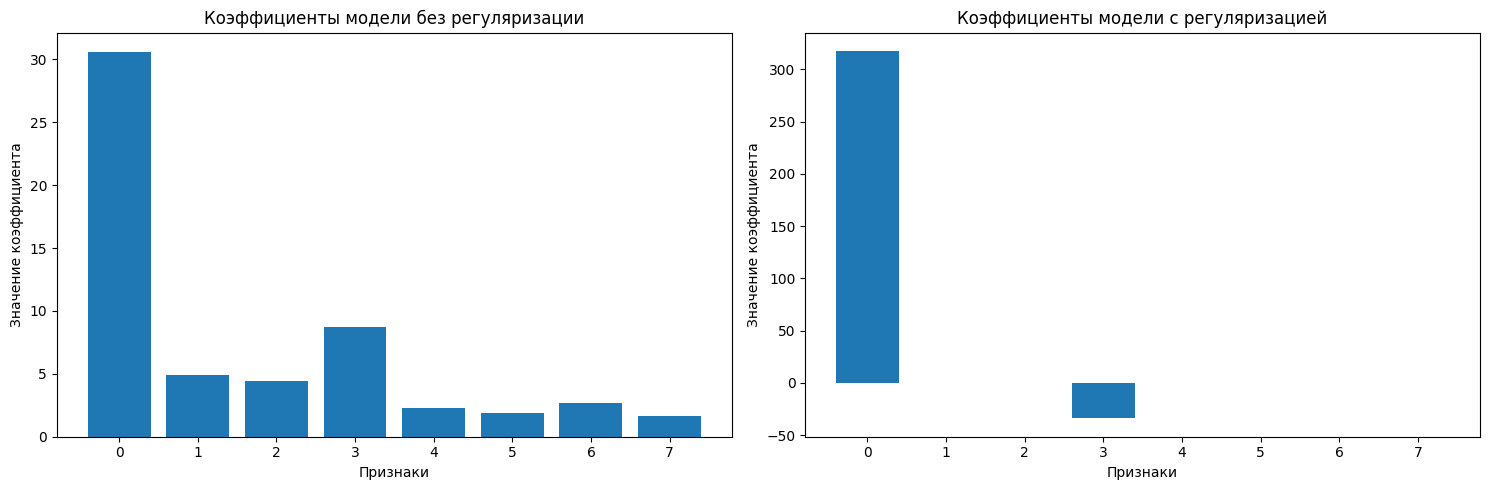

In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
import numpy as np
import matplotlib.pyplot as plt

# Обучаем модель без регуляризации
model_no_penalty = LogisticRegression(solver='lbfgs', max_iter=1000)
model_no_penalty.fit(X_processed, Y)

# Выводим коэффициенты модели без регуляризации
coefficients_no_penalty = model_no_penalty.coef_
print("Коэффициенты модели без регуляризации:", coefficients_no_penalty)

# Инициализируем модель с L1-регуляризацией
model_with_penalty = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)

# Обучаем модель с регуляризацией
model_with_penalty.fit(X_processed, Y)

# Выводим коэффициенты модели с регуляризацией
coefficients_with_penalty = model_with_penalty.coef_
print("Коэффициенты модели с регуляризацией:", coefficients_with_penalty)

# Используем SelectFromModel для отбора признаков
selector = SelectFromModel(model_with_penalty, prefit=True)
X_embedded = selector.transform(X_processed)

# Получаем список отобранных признаков
selected_features = X_processed.columns[selector.get_support()]
print("Отобранные признаки:", selected_features)

# Обучаем модель на отобранных признаках
model_embedded = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
model_embedded.fit(X_embedded, Y)

# Выводим коэффициенты модели после отбора признаков
coefficients_embedded = model_embedded.coef_
print("Коэффициенты модели после отбора признаков:", coefficients_embedded)

# Визуализация коэффициентов моделей
plt.figure(figsize=(15, 5))

# Коэффициенты модели без регуляризации
plt.subplot(1, 2, 1)
plt.bar(range(len(coefficients_no_penalty[0])), coefficients_no_penalty[0])
plt.title("Коэффициенты модели без регуляризации")
plt.xlabel("Признаки")
plt.ylabel("Значение коэффициента")

# Коэффициенты модели с регуляризацией
plt.subplot(1, 2, 2)
plt.bar(range(len(coefficients_with_penalty[0])), coefficients_with_penalty[0])
plt.title("Коэффициенты модели с регуляризацией")
plt.xlabel("Признаки")
plt.ylabel("Значение коэффициента")

plt.tight_layout()
plt.show()

In [66]:
# Преобразуем X_embedded в DataFrame
X_embedded_df = pd.DataFrame(X_embedded, columns=selected_features)

# Обучаем и оцениваем модель
model = train_and_evaluate(X_embedded_df, Y)


Точность на обучающей выборке: 0.8590
Точность на тестовой выборке: 0.8539

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.82      0.98      0.89       852
           1       0.95      0.67      0.78       558

    accuracy                           0.85      1410
   macro avg       0.88      0.82      0.84      1410
weighted avg       0.87      0.85      0.85      1410



### ⏰ **Проэксперементировать с разным количеством k, найти лучшую модель, объяснить результат**
Взял k=4, чтобы отобрать половину из признаков. filter-метод отпадает сразу, потому что связи между признаками явно нужно учитывать в моем случае. Между комментариями, репостами и количеством реакций в принципе. embedded-метод не отобрал важные признаки на мой взгляд. Поэтому лучшим для меня будет wrapper-метод.

### ⏰ **Изучить метод отбора ```SequentialFeatureSelector```, описать способ работы, сравнить результат с прошлыми методами и объяснить полученный результат**

**SequentialFeatureSelector**

Метод, при котором можно указывать алгоритму, как именно отбирать признаки.

**forward-отбор**

Начинается с пустого набора признаков. На каждой итерации добавляется один признак, который больше всего улучшает оценку модели. Процесс продолжается до тех пор, пока не будет добавлено требуемое количество признаков.

**backward-отбор**

Действует по обратному принципу. Начинается с полного набора признаков. На каждой итерации исключается один признак, который оказывает наименьшее влияние на оценку модели. Процесс продолжается, пока не останется необходимое количество признаков.

Преимущества:

•	Простота в использовании и интерпретации.

•	Подходит для небольших наборов данных, где важен точный выбор признаков.

Недостатки:

•	Требует много времени для обработки на больших наборах данных.

•	Итеративный процесс может быть вычислительно затратным, особенно при “backward” отборе.

In [101]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt

model = LogisticRegression(max_iter=1000)
X = X_processed
y = (X_processed["num_reactions"] > 0.05).astype(int)

# Выбираем 2 наиболее значимых признака с использованием "forward" (последовательного добавления)
sfs = SequentialFeatureSelector(model, n_features_to_select=4, direction='backward')

# Применяем селектор к данным
sfs.fit(X, y)

# Получаем индексы выбранных признаков
selected_features_indices = sfs.get_support(indices=True)
print("Выбранные признаки (индексы):", selected_features_indices)

# Получаем названия выбранных признаков
selected_features_names = X.columns[selected_features_indices]
print("Выбранные признаки (названия):", selected_features_names)

# Преобразуем данные, оставляя только выбранные признаки
X_selected = sfs.transform(X)
print("Данные с отобранными признаками:")
print(pd.DataFrame(X_selected, columns=selected_features_names))

Выбранные признаки (индексы): [0 1 3 5]
Выбранные признаки (названия): Index(['num_reactions', 'num_comments', 'num_loves', 'num_hahas'], dtype='object')
Данные с отобранными признаками:
      num_reactions  num_comments  num_loves  num_hahas
0          0.112314      0.024393   0.140030   0.006369
1          0.031847      0.000000   0.000000   0.000000
2          0.048195      0.011243   0.031963   0.006369
3          0.023567      0.000000   0.000000   0.000000
4          0.045223      0.000000   0.013699   0.000000
...             ...           ...        ...        ...
7045       0.018896      0.000000   0.000000   0.000000
7046       0.003397      0.000000   0.001522   0.006369
7047       0.000425      0.000000   0.001522   0.000000
7048       0.074522      0.000572   0.003044   0.000000
7049       0.003609      0.000000   0.000000   0.000000

[7050 rows x 4 columns]


In [102]:
# Преобразуем X_embedded в DataFrame
X_selected_df = pd.DataFrame(X_selected, columns=selected_features_names)

# Обучаем и оцениваем модель
model = train_and_evaluate(X_selected_df, Y)

Точность на обучающей выборке: 0.8598
Точность на тестовой выборке: 0.8525

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.82      0.98      0.89       852
           1       0.95      0.66      0.78       558

    accuracy                           0.85      1410
   macro avg       0.88      0.82      0.83      1410
weighted avg       0.87      0.85      0.85      1410



## Логистическая регрессия

**Логистическая регрессия** — это модель для задач бинарной классификации, которая предсказывает вероятность того, что наблюдение принадлежит к одному из двух классов (например, 0 или 1). Модель основана на линейной регрессии, но использует **сигмоидную функцию активации** для приведения предсказаний в диапазон от 0 до 1. Логистическая регрессия идеально подходит для задач, где нужно классифицировать данные на два класса.


#### Принцип работы логистической регрессии:
1. Сначала вычисляется линейная комбинация признаков с весами:  
y = b + w1 * x1 + w2 * x2 + w(n) * x(n), где

x - переменные

w - веса (коэфициенты регресси)

b - смещение

Затем результат линейной комбинации передается в сигмоидную функцию активации, которая преобразует результат в значение от 0 до 1.

### Функция активации (Сигмоида)
**Сигмоидная функция** в логистической регрессии используется для преобразования линейной комбинации признаков в вероятность, что наблюдение относится к классу 1. Формула сигмоиды:

sigmoida = 1 / (1 + e^-y)

Она всегда возвращает значение в диапазоне от 0 до 1, что удобно для интерпретации как вероятность принадлежности к классу 1.

Принцип работы:
1. Инициализация весов: Изначально все веса устанавливаются в нули.

2. Градиентный спуск: На каждой итерации:
- Вычисляется линейная комбинация признаков.
- Применяется сигмоидная функция для предсказания вероятностей.
- Градиенты вычисляются для обновления весов и смещения, минимизируя ошибку.

Предсказание: Для новых данных модель возвращает вероятность, которая затем конвертируется в классы 0 или 1.

In [ ]:
import numpy as np

# Сигмоидная функция
def sigmoid(z):
    # Убедимся, что z это numpy массив
    return 1 / (1 + np.exp(-z))

# Простая реализация логистической регрессии
class OwnLogisticRegression:
    def __init__(self, learning_rate=0.01, iterations=1000):
        self.learning_rate = learning_rate
        self.iterations = iterations

    # Метод для обучения модели
    def fit(self, X, y):
        # Инициализация весов
        self.weights = np.zeros(X.shape[1])
        self.bias = 0

        # Градиентный спуск
        for idx_,_ in enumerate(range(self.iterations)):
            # Линейная комбинация
            linear_model = np.dot(X, self.weights) + self.bias
            # Применяем сигмоиду для предсказания
            y_pred = sigmoid(linear_model)

            # Вычисляем градиенты
            dw = (1 / len(X)) * np.dot(X.T, (y_pred - y))
            db = (1 / len(X)) * np.sum(y_pred - y)

            # Обновляем веса и смещение
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    # Метод для предсказания
    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        print("regression",linear_model)
        y_pred = sigmoid(linear_model)
        print("sigmoid",y_pred)
        # Возвращаем метки классов (0 или 1)
        return [1 if i > 0.5 else 0 for i in y_pred]


In [ ]:
# Пример использования
X = np.array([[0.1, 1.2], [1.1, 2.2], [2.1, 1.9], [1.0, 1.0]])
y = np.array([0, 1, 1, 0])

model = OwnLogisticRegression(learning_rate=0.1, iterations=1000)
model.fit(X, y)
predictions = model.predict(X)



regression [-2.48902698  1.89302513  3.0459193  -1.27754449]
sigmoid [0.07663102 0.86910007 0.95460602 0.2179685 ]


### ⏰ Вопрос о принципе работы регресси будет в первом теоретическом модуле, важно понимание как оно работает

## 5: Кросс-валидация

**Кросс-валидация** — это метод оценки качества моделей машинного обучения, который помогает избежать переобучения и получить более надежную оценку. Она заключается в разделении данных на несколько частей и обучении модели на различных подмножествах данных, чтобы проверить ее способность обобщать на новых данных.

Основные цели кросс-валидации:

Проверить, насколько хорошо модель будет работать на новых данных.
Определить, есть ли у модели проблемы с переобучением (overfitting) или недообучением (underfitting).
Помочь выбрать наилучшую модель или гиперпараметры.

#### Виды кросс-валидации
1. K-fold Cross-Validation:

Данные делятся на K равных частей (folds). Модель обучается на K-1 частях и тестируется на оставшейся части. Процесс повторяется K раз, и результат — среднее качество по всем K итерациям.
Этот метод позволяет эффективно использовать все данные как для обучения, так и для тестирования.

2. ShuffleSplit:

Этот метод несколько раз случайно перемешивает данные и делит их на тренировочные и тестовые выборки. В отличие от K-fold, здесь нет необходимости в разделении на фиксированное количество частей.
Хорошо работает на небольших выборках данных и для оценки стабильности модели.

3. Train-Test-Validation Split:

Данные делятся на три части: тренировочные данные для обучения модели, тестовые данные для первичной оценки и валидационные данные для окончательной оценки.
Полезен для задач, где требуется как тестирование, так и финальная проверка на отложенных данных.

In [103]:
# Импорт необходимых библиотек
import numpy as np
from sklearn.model_selection import KFold, ShuffleSplit, train_test_split, cross_val_score

In [111]:
# K-Fold Cross-Validation
def k_fold_cross_validation(X, y, n_splits=5):
    kf = KFold(n_splits=15, shuffle=True, random_state=42)
    accuracies = []

    # Реализация K-Fold вручную
    for train_index, test_index in kf.split(X):
        model = LogisticRegression(max_iter=1000)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Обучение модели на тренировочной выборке
        model.fit(X_train, y_train)

        # Предсказания на тестовой выборке
        y_pred = model.predict(X_test)

        # Оценка точности
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    # Выводим среднюю точность и точности по каждому фолду
    print(f"K-Fold Cross-Validation - Средняя точность: {np.mean(accuracies)}")
    print(f"Точности по каждому фолду: {accuracies}")

# Пример использования:
k_fold_cross_validation(X = X_processed.to_numpy(), y = Y.to_numpy())


K-Fold Cross-Validation - Средняя точность: 0.8656737588652483
Точности по каждому фолду: [0.8595744680851064, 0.8957446808510638, 0.8361702127659575, 0.8574468085106383, 0.8893617021276595, 0.8808510638297873, 0.8765957446808511, 0.8702127659574468, 0.8808510638297873, 0.8553191489361702, 0.8553191489361702, 0.8574468085106383, 0.8680851063829788, 0.8595744680851064, 0.8425531914893617]


### ⏰ **Используем результат отбора признаков (выбираем по наилучшей точности), делаем кросс валидацию и объясняем результат + перебираем параметры n_splits**
n_splits выбрал 15. Средняя точность составила 86.5%, что очень неплохо.

In [117]:
# ShuffleSplit Cross-Validation
def shuffle_split_cross_validation(X, y, n_splits=5, test_size=0.4):
    ss = ShuffleSplit(n_splits=15, test_size=test_size)
    accuracies = []

    # Реализация ShuffleSplit вручную
    for train_index, test_index in ss.split(X):
        model = LogisticRegression(max_iter=1000)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Обучение модели на тренировочной выборке
        model.fit(X_train, y_train)

        # Предсказания на тестовой выборке
        y_pred = model.predict(X_test)

        # Оценка точности
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    # Выводим среднюю точность и точности по каждому разделению
    print(f"ShuffleSplit Cross-Validation - Средняя точность: {np.mean(accuracies)}")
    print(f"Точности по каждому разделению: {accuracies}")

# Пример использования:
shuffle_split_cross_validation(X_processed.to_numpy(), Y.to_numpy())


ShuffleSplit Cross-Validation - Средняя точность: 0.8488652482269502
Точности по каждому разделению: [0.8471631205673759, 0.8333333333333334, 0.8613475177304964, 0.8531914893617021, 0.8443262411347517, 0.8570921985815603, 0.8528368794326241, 0.8382978723404255, 0.8588652482269503, 0.85, 0.851063829787234, 0.8365248226950355, 0.85, 0.8468085106382979, 0.8521276595744681]


### ⏰ **Используем результат отсечения выбросов, делаем кросс валидацию и объясняем результат + перебираем параметры n_splits**
Параметр оставил равным 15. Точность этого вида заметно ниже, чем у предыдущего.

In [118]:
# Train-Test-Validation Split
def train_test_validation_split(X, y):
    model = LogisticRegression(max_iter=1000)
    # Разделяем данные на тренировочные и оставшиеся (валидация + тест)
    X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42)

    # Разделяем оставшиеся данные на валидационные и тестовые
    X_train_train, X_test, y_train_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Обучаем модель на тренировочных данных
    model.fit(X_train_train, y_train_train)

    # Оцениваем на валидационных данных
    y_valid_pred = model.predict(X_validation)
    validation_accuracy = accuracy_score(y_validation, y_valid_pred)
    print(f"Точность на валидационных данных: {validation_accuracy}")

    # Оцениваем на тестовых данных
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Точность на тестовых данных: {test_accuracy}")

# Пример использования:
train_test_validation_split(X_processed.to_numpy(), Y.to_numpy())


Точность на валидационных данных: 0.85177304964539
Точность на тестовых данных: 0.8670212765957447


### ⏰ **Используем результат отсечения выбросов или лучший отбор признаков, делаем кросс валидацию и объясняем результат + перебираем параметры n_splits**
В этом методе данные всегда делятся на три части. В принципе точность оказалась средней между двумя предыдущими видами.

### Когда использовать каждый метод:
- K-fold Cross-Validation: Отлично подходит для более точной оценки модели, особенно на небольших наборах данных. Используется, когда нужно получить стабильную оценку по всем данным.

- ShuffleSplit Cross-Validation: Хорошо работает на небольших выборках, где нужно много раз случайно перемешивать и проверять модель. Это может помочь увидеть, как модель работает на различных случайных подвыборках данных.

- Train-Test-Validation Split: Используется, когда нужно четко разделить данные для обучения, подбора параметров и финальной оценки. Подходит для больших наборов данных, где важно иметь отложенную тестовую выборку для окончательной проверки.

### ⏰ **Объяснить, какой из методов подходит для вашего датасета**

K-fold Cross-Validation прекрасно подойдет для моего датасета. Мешать данные нет необходимости и разделять их тоже.